In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from metal.contrib.slicing.synthetics.geometric_synthetics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
k = 2
m = 20
n = 5000
unipolar = True

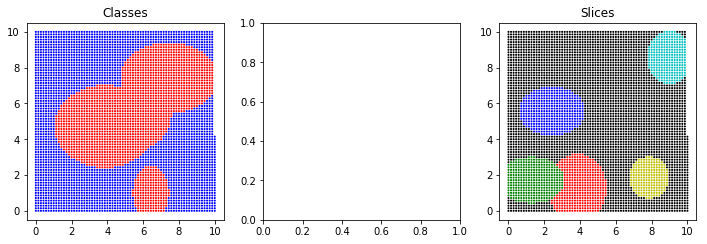

In [3]:
L, X, Y, Z = generate_dataset(
    k, m, n, 
    unipolar=unipolar,
    L_kwargs=({'max_r': 7} if unipolar else {'max_r': 5}),
    Z_kwargs={'num_slices': 5},
)

### Analyze Data

In [4]:
from scipy.sparse import csr_matrix
import torch

L = csr_matrix(L)
X = torch.Tensor(X)

In [5]:
from metal.utils import split_data

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, 
                            splits=[0.8, 0.1, 0.1], 
                            shuffle=True, seed=123)

In [6]:
from metal.analysis import lf_summary

df = lf_summary(Ls[1], Ys[1])
df

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,2,0.142,0.120,0.090,58,13,0.816901
1,1,0.030,0.030,0.020,4,11,0.266667
2,1,0.090,0.086,0.054,36,9,0.800000
3,2,0.384,0.356,0.238,150,42,0.781250
4,1,0.188,0.168,0.112,66,28,0.702128
5,1,0.118,0.106,0.086,31,28,0.525424
6,1,0.020,0.020,0.018,8,2,0.800000
7,2,0.208,0.198,0.146,77,27,0.740385
8,1,0.116,0.094,0.074,30,28,0.517241
9,1,0.044,0.042,0.040,6,16,0.272727


In [7]:
df.mean()

Polarity      1.300000
Coverage      0.123600
Overlaps      0.114000
Conflicts     0.081200
Correct      44.150000
Incorrect    17.650000
Emp. Acc.     0.646491
dtype: float64

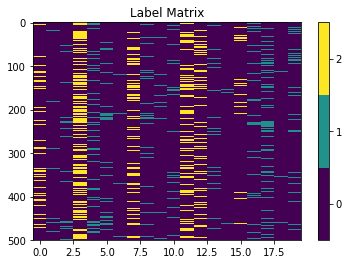

In [8]:
from metal.contrib.visualization.analysis import view_label_matrix

view_label_matrix(Ls[1])

In [9]:
# num_votes = Ls[0].sum(axis=1)
# plt.hist(num_votes)

In [10]:
# np.save('synthetic_data.npy', (L, Y))

### Add pepper

In [11]:
# from collections import Counter

# Ls[0]

In [12]:
# df = lf_summary(Ls[1], Ys[1])
# df.mean()

In [13]:
# view_label_matrix(L)

In [14]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.utils import add_pepper

for pepper in [0, 0.05, 0.1, 0.2, 0.5]:
    print(pepper)
    L_temp = add_pepper(Ls[0], pepper)

    label_model = SnorkelLabelModel()
    label_model.train_model(L_temp)

    label_model.score((Ls[1], Ys[1]))

0
Accuracy: 0.786
        y=1    y=2   
 l=1    155    66    
 l=2    41     238   


0.786

0.05


/Users/bradenjh/anaconda3/envs/metal/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Accuracy: 0.780
        y=1    y=2   
 l=1    163    77    
 l=2    33     227   


0.78

0.1
Accuracy: 0.722
        y=1    y=2   
 l=1    177    120   
 l=2    19     184   


0.722

0.2
Accuracy: 0.488
        y=1    y=2   
 l=1    187    247   
 l=2     9     57    


0.488

0.5
Accuracy: 0.418
        y=1    y=2   
 l=1    189    284   
 l=2     7     20    


0.418

# Learn

In [ ]:
# L, Y = np.load('synthetic_data.npy')

### Snorkel LabelModel

In [ ]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

In [ ]:
from metal.metrics import accuracy_score

Y_train_ps = label_model.predict_proba(Ls[0])
Y_train_p = label_model.predict(Ls[0])

Y_dev_ps = label_model.predict_proba(Ls[0])
Y_dev_p = label_model.predict(Ls[1])
accuracy_score(Ys[1], Y_dev_p)

In [ ]:
from metal.contrib.visualization.analysis import (
    plot_predictions_histogram, 
    plot_probabilities_histogram,
)
    
plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")
plot_predictions_histogram(Y_dev_p, Ys[1], title="Label Distribution")

## Compare Baselines

In [ ]:
# from torch.utils.data import DataLoader
# from metal.utils import SlicingDataset
# from metal.contrib.slicing.utils import evaluate_slicing

# eval_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]))

# results = {}
# for model_name, model in trained_models.items():
#     scores = evaluate_slicing(model, eval_loader, verbose=False)
#     results[model_name] = {k:v['accuracy'] for k,v in scores.items()}
    
# import pandas as pd
# pd.DataFrame.from_dict(results)

### EndModel

In [ ]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

train_loader = DataLoader(
    SlicingDataset(Xs[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

In [ ]:
from metal.end_model import EndModel
import torch

end_model = EndModel([2,10,10,2])
end_model.train_model(train_loader, dev_data=(Xs[1], Ys[1]), l2=0.0, 
                      n_epochs=25, print_every=5, validation_metric='accuracy', 
                      disable_prog_bar=True)
end_model.score((Xs[1], Ys[1]))

### SliceModel

In [ ]:
# from torch.utils.data import DataLoader
# from metal.utils import SlicingDataset

# Ls_tensors = [torch.Tensor(np.asarray(L.todense())) for L in Ls]

# train_loader = DataLoader(
#     SlicingDataset(Xs[0], Ls_tensors[0], Y_train_ps),
#     batch_size=256,
#     shuffle=True
# )

# dev_loader = DataLoader(
#     SlicingDataset(Xs[1], Ys[1]),
#     batch_size=256,
# )

In [ ]:
# import torch.nn as nn
# from metal.contrib.slicing.online_dp import SliceDPModel, MLPModule

# n, m = Ls[0].shape
# input_dim = Xs[0].shape[1]

# input_module = MLPModule(input_dim, 10, [10], bias=True)
# slice_model = SliceDPModel(input_module, r=10, m=m, reweight=False, slice_weight=0.1, 
#                            verbose=False)
# slice_model.train_model(
#     train_loader,
#     dev_data=dev_loader,
#     l2=0.0, n_epochs=50,
#     print_every=5, validation_metric='accuracy',
#     log_writer=None,
#     verbose=True, 
#     use_cuda=False,
#     disable_prog_bar=True,
# )

### New SliceModel

In [ ]:
from metal.contrib.slicing.online_dp import SliceHatModel

# base_model = EndModel([2,20,20,2], verbose=False)
slicer = SliceHatModel(end_model, m, slice_weight=0.1)

slicer.train_model(
    train_loader,
    dev_data=dev_loader,
    lr=0.05,
    l2=0.0, n_epochs=50,
    print_every=5, validation_metric='accuracy',
    log_writer=None,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

In [ ]:
from metal.contrib.slicing.utils import evaluate_slicing

from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

eval_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]))

_ = evaluate_slicing(end_model, eval_loader, verbose=False)
_ = evaluate_slicing(slice_model, eval_loader, verbose=False)
_ = evaluate_slicing(slicer, eval_loader, verbose=False)

In [ ]:
# L_pred = np.round(slicer.predict_L_proba(Xs[1]).numpy())
# L_pred[L_pred == 0] = 2
# accuracy_score(Ls[1].reshape(-1,1), L_pred.reshape(-1,1), ignore_in_gold=[0])

In [ ]:
# ((Ls[1] == L_pred).sum(axis=0)/(Ls[1] != 0).sum(axis=0)).mean()